<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/LSTM-NoveltyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomalies in Streaming Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import preprocessing
from matplotlib import pyplot as plt

# 1. Read the dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snu/w4/실습자료/hw-rnn-anomalystream-skeleton/data/ambient_temperature_system_failure.csv')
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


# 2. Preprocess the dataset

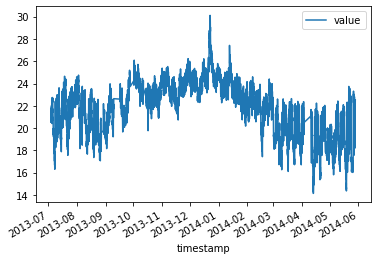

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5 / 9
df.plot(x='timestamp', y='value')

### Create four additional features

In [6]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & 
                  (df['hours'] <= 22)).astype(int)
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['weekday'] = (df['dayofweek'] < 5).astype(int)

### Standardize the added features

In [7]:
data_n = df[['value', 'hours', 'daylight', 
             'dayofweek', 'weekday']]
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(data_n)
data_n = pd.DataFrame(scaled)

In [19]:
data_n.head()

,0,1,2,3,4
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132


### Unroll the features

In [9]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,length=50):
    result = []
    for i in range(len(data) - length + 1):
        result.append(data[i : i + length])
    return np.asarray(result)

In [10]:
X = data_n[:-1].values
X = unroll(X, length = 50)
print(f"X shape: {X.shape}")

X shape: (7217, 50, 5)


In [11]:
y = data_n[1:][0].values
y = y[-X.shape[0]:]

print(f"Y shape: {y.shape}")

Y shape: (7217,)


In [12]:
test_size = 1000

X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

In [13]:
# see the shape
print(f"x_train: {X_train.shape} " 
      f"y_train: {y_train.shape}")

print(f"x_test : {X_test.shape} "
      f"y_test : {y_test.shape}")

x_train: (6217, 50, 5) y_train: (6217,)
x_test : (1000, 50, 5) y_test : (1000,)


# 3. Now make the RNN model to predict

In [14]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

#### (a) Define LSTM models

In [15]:
def create_lstm(pkeep, hid1=50, hid2=100):
    model = Sequential()
    model.add(LSTM(hid1, return_sequences = True))
    model.add(Dropout(1-pkeep))

    model.add(LSTM(hid2))
    model.add(Dropout(1-pkeep))

    model.add(Dense(units = 1))
    
    return model

#### (b) Train the model
* Configure the epoch and batch size 
* Set loss function and optimizer
* Train the model

In [16]:
pkeep = 0.7
batch_size = 256
epochs = 10

In [18]:
model = create_lstm(pkeep)
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.1, callbacks = [EarlyStopping(monitor="val_loss", patience = 7)])

Epoch 1/10
22/22 [==============================] - 12s 333ms/step - loss: 0.2209 - val_loss: 0.1835
Epoch 2/10
22/22 [==============================] - 6s 291ms/step - loss: 0.0768 - val_loss: 0.1350
Epoch 3/10
22/22 [==============================] - 6s 289ms/step - loss: 0.0633 - val_loss: 0.1057
Epoch 4/10
22/22 [==============================] - 6s 287ms/step - loss: 0.0568 - val_loss: 0.1013
Epoch 5/10
22/22 [==============================] - 6s 294ms/step - loss: 0.0562 - val_loss: 0.0928
Epoch 6/10
22/22 [==============================] - 6s 293ms/step - loss: 0.0545 - val_loss: 0.0923
Epoch 7/10
22/22 [==============================] - 6s 289ms/step - loss: 0.0521 - val_loss: 0.0868
Epoch 8/10
22/22 [==============================] - 6s 284ms/step - loss: 0.0508 - val_loss: 0.0801
Epoch 9/10
22/22 [==============================] - 6s 286ms/step - loss: 0.0502 - val_loss: 0.0812
Epoch 10/10
22/22 [==============================] - 6s 290ms/step - loss: 0.0492 - val_loss: 0.085

#### (c) Check the result and detect 10 anomalies with maximum differences 
* Compute the differences for the test instances (absolute value).
    
* Plot the true and predicted value using `matplotlib`.
    
* Find the 10 anomalies and plot into the previus figure.



In [20]:
preds = model.predict(X_test)
diffs = list(abs(y_test - preds.flatten()))

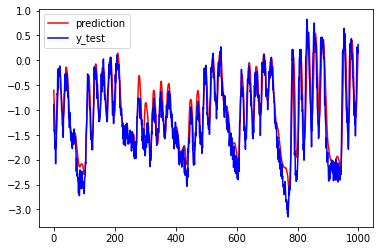

In [21]:
fig, axs = plt.subplots()
axs.plot(preds, color = 'red', label = 'prediction')
axs.plot(y_test, color = 'blue', label = 'y_test')
plt.legend(loc = 'upper left')
plt.show()

In [23]:
# ★★★★★
n_outliers = 10
argsorted = np.array(diffs).argsort()
anomalies = argsorted[-n_outliers:][::-1]

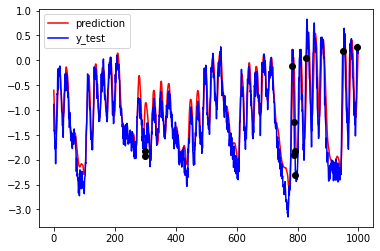

In [27]:
fig,axs = plt.subplots()
axs.plot(preds, color = 'red', label = 'prediction')
axs.plot(y_test, color = 'blue', label='y_test')
axs.scatter(anomalies, [y_test[i] for i in anomalies], color = 'black', zorder = 10)
plt.legend(loc = 'upper left')
plt.show()